# Week 9, Day 3: Backpropagation

## 🎯 Today's Objectives
- Understand the chain rule of calculus
- Learn how gradients flow backward through networks
- Implement backpropagation from scratch
- Use PyTorch's automatic differentiation

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
torch.manual_seed(42)

print("✅ Libraries loaded!")
print(f"📚 Day 3: Backpropagation")

✅ Libraries loaded!
📚 Day 3: Backpropagation


---

## Part 1: The Chain Rule

### How Neural Networks Learn

To minimize loss, we need gradients:

$$\frac{\partial L}{\partial w} = ?$$

The chain rule allows us to compute this:

$$\frac{\partial L}{\partial w} = \frac{\partial L}{\partial y} \cdot \frac{\partial y}{\partial w}$$

For a composition: $f(g(x))$
$$\frac{df}{dx} = \frac{df}{dg} \cdot \frac{dg}{dx}$$

In [2]:
# Simple chain rule example
print("CHAIN RULE EXAMPLE")
print("="*60)

# y = (2x + 3)^2
# Let u = 2x + 3, y = u^2

# Then: dy/dx = dy/du * du/dx = 2u * 2 = 4(2x + 3)

x = 2.0
u = 2*x + 3
y = u**2

# Analytical gradient
dy_du = 2 * u
du_dx = 2
dy_dx = dy_du * du_dx

print(f"y = (2x + 3)² at x = {x}")
print(f"\nForward pass:")
print(f"  u = 2x + 3 = {u}")
print(f"  y = u² = {y}")
print(f"\nBackward pass (chain rule):")
print(f"  dy/du = 2u = {dy_du}")
print(f"  du/dx = 2")
print(f"  dy/dx = dy/du × du/dx = {dy_du} × {du_dx} = {dy_dx}")

# Verify with numerical gradient
eps = 1e-5
numerical_grad = ((2*(x+eps) + 3)**2 - (2*(x-eps) + 3)**2) / (2*eps)
print(f"\n✓ Numerical verification: {numerical_grad:.4f}")

CHAIN RULE EXAMPLE
y = (2x + 3)² at x = 2.0

Forward pass:
  u = 2x + 3 = 7.0
  y = u² = 49.0

Backward pass (chain rule):
  dy/du = 2u = 14.0
  du/dx = 2
  dy/dx = dy/du × du/dx = 14.0 × 2 = 28.0

✓ Numerical verification: 28.0000


---

## Part 2: Backpropagation from Scratch

Let's implement a simple 2-layer network manually to understand backprop.

In [3]:
class ManualNeuralNet:
    """
    2-layer neural network with manual backpropagation.
    
    Architecture: x -> Linear -> ReLU -> Linear -> MSE Loss
    """
    def __init__(self, input_dim, hidden_dim, output_dim):
        # Xavier initialization
        self.W1 = np.random.randn(input_dim, hidden_dim) * np.sqrt(2.0 / input_dim)
        self.b1 = np.zeros(hidden_dim)
        self.W2 = np.random.randn(hidden_dim, output_dim) * np.sqrt(2.0 / hidden_dim)
        self.b2 = np.zeros(output_dim)
        
        # Gradients
        self.dW1 = None
        self.db1 = None
        self.dW2 = None
        self.db2 = None
        
        # Cache for backward pass
        self.cache = {}
        
    def relu(self, x):
        return np.maximum(0, x)
    
    def relu_derivative(self, x):
        return (x > 0).astype(float)
    
    def forward(self, X):
        """Forward pass with caching."""
        # Layer 1
        z1 = X @ self.W1 + self.b1
        a1 = self.relu(z1)
        
        # Layer 2
        z2 = a1 @ self.W2 + self.b2
        
        # Cache for backward pass
        self.cache = {'X': X, 'z1': z1, 'a1': a1, 'z2': z2}
        
        return z2
    
    def backward(self, y_true, y_pred):
        """
        Backward pass using chain rule.
        
        Loss = MSE = (1/n) * sum((y_true - y_pred)^2)
        """
        m = y_true.shape[0]
        
        # Get cached values
        X = self.cache['X']
        z1 = self.cache['z1']
        a1 = self.cache['a1']
        
        # dL/dy_pred = 2(y_pred - y_true) / m
        dL_dy = 2 * (y_pred - y_true) / m
        
        # Layer 2 gradients
        # dL/dW2 = dL/dy * dy/dW2 = dL/dy * a1^T
        self.dW2 = a1.T @ dL_dy
        self.db2 = np.sum(dL_dy, axis=0)
        
        # Backprop through layer 2
        dL_da1 = dL_dy @ self.W2.T
        
        # Backprop through ReLU
        dL_dz1 = dL_da1 * self.relu_derivative(z1)
        
        # Layer 1 gradients
        self.dW1 = X.T @ dL_dz1
        self.db1 = np.sum(dL_dz1, axis=0)
        
    def update(self, lr):
        """Update weights using gradients."""
        self.W1 -= lr * self.dW1
        self.b1 -= lr * self.db1
        self.W2 -= lr * self.dW2
        self.b2 -= lr * self.db2

# Create and test
net = ManualNeuralNet(input_dim=5, hidden_dim=10, output_dim=1)

# Sample data
X = np.random.randn(4, 5)
y = np.random.randn(4, 1)

# Forward pass
y_pred = net.forward(X)

# Backward pass
net.backward(y, y_pred)

print("MANUAL BACKPROPAGATION")
print("="*60)
print(f"Input shape: {X.shape}")
print(f"Output shape: {y_pred.shape}")
print(f"\nGradient shapes:")
print(f"  dW1: {net.dW1.shape}")
print(f"  db1: {net.db1.shape}")
print(f"  dW2: {net.dW2.shape}")
print(f"  db2: {net.db2.shape}")

MANUAL BACKPROPAGATION
Input shape: (4, 5)
Output shape: (4, 1)

Gradient shapes:
  dW1: (5, 10)
  db1: (10,)
  dW2: (10, 1)
  db2: (1,)


TRAINING MANUAL NETWORK
Epoch  40 | Loss: 0.288570
Epoch  80 | Loss: 0.145740
Epoch 120 | Loss: 0.101363
Epoch 160 | Loss: 0.077712
Epoch 200 | Loss: 0.062764


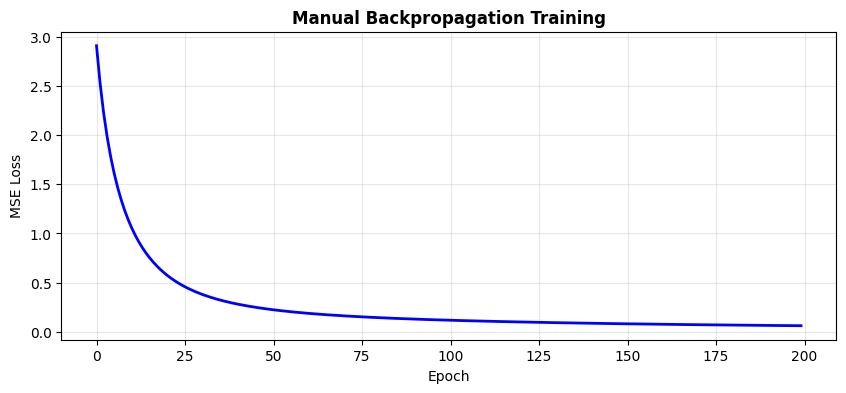


📊 Final Loss: 0.062764


In [4]:
# Train the manual network
print("TRAINING MANUAL NETWORK")
print("="*60)

# Generate data
np.random.seed(42)
X_train = np.random.randn(100, 5)
y_train = 0.5 * X_train[:, 0:1] - 0.3 * X_train[:, 1:2] + np.random.randn(100, 1) * 0.1

net = ManualNeuralNet(5, 20, 1)
losses = []

for epoch in range(200):
    # Forward
    y_pred = net.forward(X_train)
    loss = np.mean((y_train - y_pred)**2)
    losses.append(loss)
    
    # Backward
    net.backward(y_train, y_pred)
    
    # Update
    net.update(lr=0.01)
    
    if (epoch + 1) % 40 == 0:
        print(f"Epoch {epoch+1:3d} | Loss: {loss:.6f}")

plt.figure(figsize=(10, 4))
plt.plot(losses, 'b-', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Manual Backpropagation Training', fontweight='bold')
plt.grid(True, alpha=0.3)
plt.show()

print(f"\n📊 Final Loss: {losses[-1]:.6f}")

### 📊 OUTPUT EXPLANATION:

The loss decreases as the network learns! This happens because:

1. **Forward pass**: Compute predictions
2. **Compute loss**: Measure error
3. **Backward pass**: Calculate gradients using chain rule
4. **Update**: Move weights in the direction that reduces loss

---

## Part 3: PyTorch Autograd

PyTorch computes gradients automatically!

In [5]:
# PyTorch automatic differentiation
print("PYTORCH AUTOGRAD")
print("="*60)

# Create tensor with gradient tracking
x = torch.tensor(2.0, requires_grad=True)

# Forward pass
y = (2*x + 3)**2

print(f"x = {x.item()}")
print(f"y = (2x + 3)² = {y.item()}")

# Backward pass - computes gradients
y.backward()

print(f"\ndy/dx = {x.grad.item()}")
print(f"Expected: 4(2x + 3) = 4(2*2 + 3) = 28 ✓")

PYTORCH AUTOGRAD
x = 2.0
y = (2x + 3)² = 49.0

dy/dx = 28.0
Expected: 4(2x + 3) = 4(2*2 + 3) = 28 ✓


In [6]:
# More complex example with matrices
print("MATRIX GRADIENTS")
print("="*60)

# Weight matrix
W = torch.randn(3, 2, requires_grad=True)
b = torch.zeros(2, requires_grad=True)

# Input
x = torch.randn(4, 3)  # Batch of 4, 3 features
y_true = torch.randn(4, 2)

# Forward pass
y_pred = x @ W + b
loss = ((y_pred - y_true)**2).mean()

print(f"Input shape: {x.shape}")
print(f"Weight shape: {W.shape}")
print(f"Output shape: {y_pred.shape}")
print(f"Loss: {loss.item():.4f}")

# Backward pass
loss.backward()

print(f"\nGradient of W (dL/dW):")
print(W.grad)
print(f"\nGradient of b (dL/db): {b.grad}")

MATRIX GRADIENTS
Input shape: torch.Size([4, 3])
Weight shape: torch.Size([3, 2])
Output shape: torch.Size([4, 2])
Loss: 1.1383

Gradient of W (dL/dW):
tensor([[ 0.5850,  0.2121],
        [-1.1932,  0.2158],
        [-0.7827,  0.2118]])

Gradient of b (dL/db): tensor([-0.0888, -0.1287])


PYTORCH NEURAL NETWORK
Epoch  40 | Loss: 0.200284
Epoch  80 | Loss: 0.115516
Epoch 120 | Loss: 0.068181
Epoch 160 | Loss: 0.042840
Epoch 200 | Loss: 0.029807


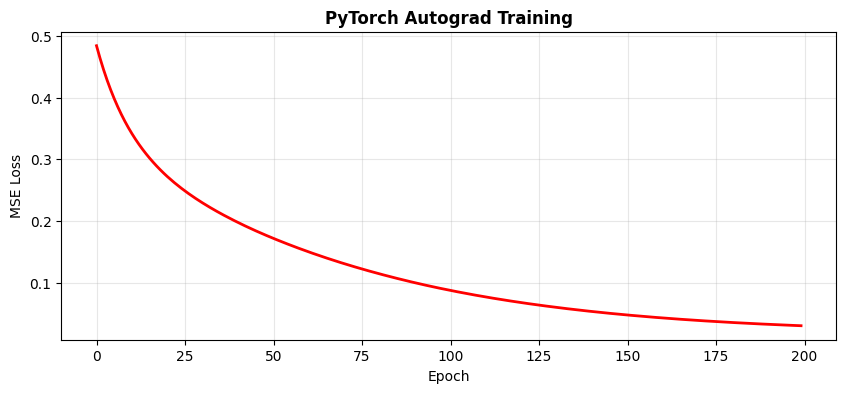

In [7]:
# Full neural network with autograd
print("PYTORCH NEURAL NETWORK")
print("="*60)

# Same data
X_train = torch.FloatTensor(np.random.randn(100, 5))
y_train = 0.5 * X_train[:, 0:1] - 0.3 * X_train[:, 1:2] + torch.randn(100, 1) * 0.1

# Model
model = nn.Sequential(
    nn.Linear(5, 20),
    nn.ReLU(),
    nn.Linear(20, 1)
)

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

losses_pytorch = []

for epoch in range(200):
    # Forward
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    losses_pytorch.append(loss.item())
    
    # Backward (PyTorch does this automatically!)
    optimizer.zero_grad()  # Clear previous gradients
    loss.backward()        # Compute gradients
    optimizer.step()       # Update weights
    
    if (epoch + 1) % 40 == 0:
        print(f"Epoch {epoch+1:3d} | Loss: {loss.item():.6f}")

plt.figure(figsize=(10, 4))
plt.plot(losses_pytorch, 'r-', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('PyTorch Autograd Training', fontweight='bold')
plt.grid(True, alpha=0.3)
plt.show()

---

## Part 4: Gradient Flow Visualization

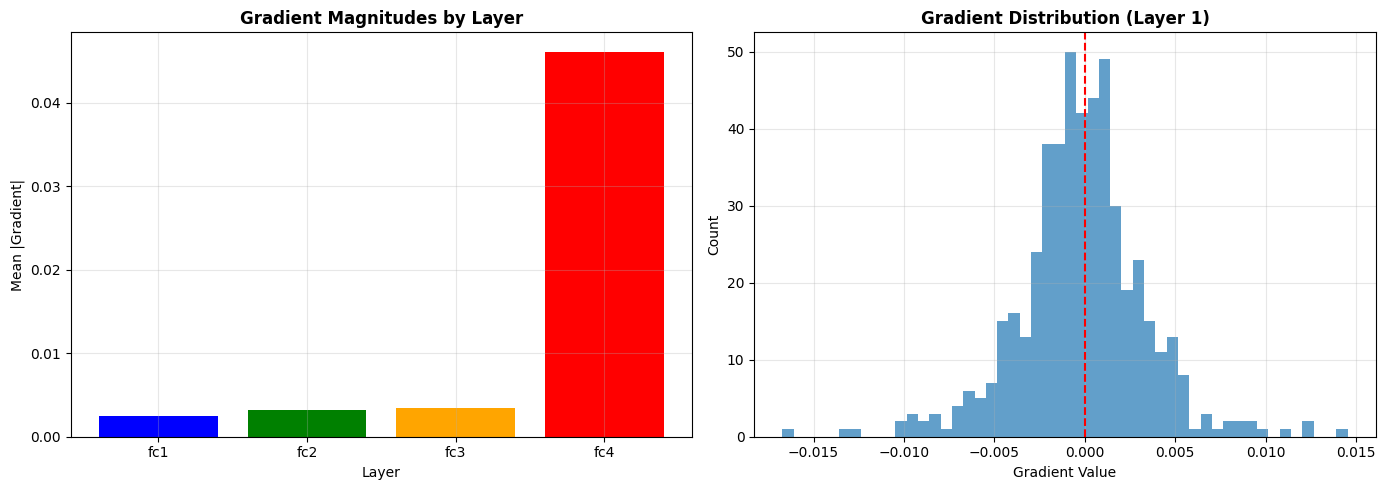


📊 GRADIENT FLOW ANALYSIS:
  fc1: 0.002537
  fc2: 0.003213
  fc3: 0.003437
  fc4: 0.046127

💡 If gradients are much smaller in earlier layers,
   that's the 'vanishing gradient' problem!


In [8]:
# Visualize gradient flow through a network
class GradientVisualizer(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(10, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 50)
        self.fc4 = nn.Linear(50, 1)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return self.fc4(x)

# Create model and do one backward pass
model = GradientVisualizer()
x = torch.randn(32, 10)
y = torch.randn(32, 1)

output = model(x)
loss = ((output - y)**2).mean()
loss.backward()

# Get gradient magnitudes per layer
grad_mags = []
layer_names = []

for name, param in model.named_parameters():
    if 'weight' in name:
        grad_mag = param.grad.abs().mean().item()
        grad_mags.append(grad_mag)
        layer_names.append(name.replace('.weight', ''))

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gradient magnitudes by layer
axes[0].bar(layer_names, grad_mags, color=['blue', 'green', 'orange', 'red'])
axes[0].set_xlabel('Layer')
axes[0].set_ylabel('Mean |Gradient|')
axes[0].set_title('Gradient Magnitudes by Layer', fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Gradient distribution for one layer
grads = model.fc1.weight.grad.flatten().numpy()
axes[1].hist(grads, bins=50, alpha=0.7)
axes[1].axvline(x=0, color='r', linestyle='--')
axes[1].set_xlabel('Gradient Value')
axes[1].set_ylabel('Count')
axes[1].set_title('Gradient Distribution (Layer 1)', fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 GRADIENT FLOW ANALYSIS:")
print("="*60)
for name, mag in zip(layer_names, grad_mags):
    print(f"  {name}: {mag:.6f}")
print("\n💡 If gradients are much smaller in earlier layers,")
print("   that's the 'vanishing gradient' problem!")

---

## Part 5: Common Gradient Issues

In [10]:
# Vanishing gradients with Sigmoid
print("VANISHING GRADIENTS (Sigmoid Network)")
print("="*60)

class SigmoidNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Linear(10, 50),
            nn.Linear(50, 50),
            nn.Linear(50, 50),
            nn.Linear(50, 50),
            nn.Linear(50, 1)
        ])
        
    def forward(self, x):
        for layer in self.layers[:-1]:
            x = torch.sigmoid(layer(x))  # Sigmoid causes vanishing gradients!
        return self.layers[-1](x)

class ReLUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Linear(10, 50),
            nn.Linear(50, 50),
            nn.Linear(50, 50),
            nn.Linear(50, 50),
            nn.Linear(50, 1)
        ])
        
    def forward(self, x):
        for layer in self.layers[:-1]:
            x = torch.relu(layer(x))  # ReLU helps prevent vanishing gradients
        return self.layers[-1](x)

# Compare ReLU vs Sigmoid
def get_grad_norms(model, x, y):
    model.zero_grad()
    out = model(x)
    loss = ((out - y)**2).mean()
    loss.backward()
    
    norms = []
    for i, layer in enumerate(model.layers):
        if hasattr(layer, 'weight'):
            norms.append(layer.weight.grad.norm().item())
    return norms

x = torch.randn(32, 10)
y = torch.randn(32, 1)

# Sigmoid network
sigmoid_net = SigmoidNet()
sigmoid_grads = get_grad_norms(sigmoid_net, x, y)

# ReLU network
relu_net = ReLUNet()  # Uses ReLU with same architecture
relu_grads = get_grad_norms(relu_net, x, y)

print(f"Layer  Sigmoid Grad Norm   ReLU Grad Norm")
print("-"*45)
for i, (s, r) in enumerate(zip(sigmoid_grads, relu_grads)):
    print(f"  {i+1}     {s:>12.6f}     {r:>12.6f}")

print("\n⚠️  Notice how Sigmoid gradients decrease dramatically!")

VANISHING GRADIENTS (Sigmoid Network)
Layer  Sigmoid Grad Norm   ReLU Grad Norm
---------------------------------------------
  1         0.000290         0.038165
  2         0.004567         0.091478
  3         0.038950         0.088296
  4         0.353326         0.159629
  5         2.557333         0.293192

⚠️  Notice how Sigmoid gradients decrease dramatically!


---

## 📝 Day 3 Summary

### Key Concepts:

1. **Chain Rule**: Derivatives of compositions
   $$\frac{df}{dx} = \frac{df}{dg} \cdot \frac{dg}{dx}$$

2. **Backpropagation Steps**:
   - Forward pass (cache intermediate values)
   - Compute loss
   - Backward pass (apply chain rule)
   - Update weights

3. **PyTorch Autograd**:
   - `requires_grad=True` to track gradients
   - `.backward()` computes all gradients
   - `optimizer.zero_grad()` clears gradients

### Common Issues:
- **Vanishing gradients**: Use ReLU, BatchNorm, skip connections
- **Exploding gradients**: Gradient clipping, proper initialization

In [11]:
print("""
╔══════════════════════════════════════════════════════════════════╗
║               DAY 3 COMPLETE: BACKPROPAGATION                    ║
╠══════════════════════════════════════════════════════════════════╣
║  ✓ Chain rule of calculus                                       ║
║  ✓ Manual backpropagation implementation                        ║
║  ✓ PyTorch autograd                                             ║
║  ✓ Gradient flow visualization                                  ║
║  ✓ Vanishing gradient problem                                   ║
╚══════════════════════════════════════════════════════════════════╝
""")


╔══════════════════════════════════════════════════════════════════╗
║               DAY 3 COMPLETE: BACKPROPAGATION                    ║
╠══════════════════════════════════════════════════════════════════╣
║  ✓ Chain rule of calculus                                       ║
║  ✓ Manual backpropagation implementation                        ║
║  ✓ PyTorch autograd                                             ║
║  ✓ Gradient flow visualization                                  ║
║  ✓ Vanishing gradient problem                                   ║
╚══════════════════════════════════════════════════════════════════╝

